In [60]:
import pandas as pd
import glob
from datetime import datetime
import matplotlib.pyplot as plt
import requests
import os
pd.set_option('display.max_columns', None)

In [ ]:
years = ['2015', '2016', '2017', '2018' ,'2019' ,'2020' ,'2021', '2022', '2023']

In [ ]:
for i in years:
    df = pd.read_csv(f"raw_data/ust_aq_timeseries_{i}.csv")

    pivot_df = pd.pivot_table(df, values='the_value', index=['station_name', 'endtime'],
                       columns=['pollutantnotation'], aggfunc=lambda x: 'n/a' if x.empty else x.iloc[0]).rename_axis(columns=None).reset_index()

    # Convert the 'time' column to datetime format
    pivot_df['endtime'] = pd.to_datetime(pivot_df['endtime'])

    pivot_df.sort_values(by=['station_name', 'endtime'], inplace=True)

    # Set 'time' column as the DataFrame's index
    pivot_df.set_index('endtime', inplace=True)

    # Resample to create complete hourly time range for each station
    # The 'ffill' method fills missing values using the last available value (forward fill)
    # The 'fillna' method replaces any remaining missing values with 'N/A'
    hourly_range = pd.date_range(start=pivot_df.index.min(), end=pivot_df.index.max(), freq='1H')
    result = pivot_df.groupby('station_name').apply(lambda x: x.reindex(hourly_range, method='ffill')).fillna('N/A')

    # Reset the MultiIndex
    reset_df = result.reset_index(level='station_name', drop=True)
    df = reset_df.reset_index().rename(columns={'index': 'endtime'})
    df = df[df['station_name'] != 'N/A']

    # merge df new df with pivoted df to remove ffilled readings
    df = df [['station_name', 'endtime']]
    pivot_df = pivot_df.reset_index().rename(columns={'index': 'endtime'})

    df = pd.merge(df, pivot_df,  how='left', left_on=['endtime','station_name'], right_on = ['endtime','station_name'])
    df.to_csv(f'raw_data/new_{i}.csv', index=False)
    print(f"Finished {i}")

In [2]:
df = pd.concat(map(pd.read_csv, glob.glob("raw_data/new_*.csv")))
df = df.drop_duplicates()
df.head(3)

,station_name,endtime,H2S,NO,NO2,NOX as NO2,O3,PM10,PM2.5,SO2,CO,PM1
0,Akureyri Strandgata (við Hof),2019-01-01 00:00:00,NaN,1.34583,6.0629,7.43397,NaN,22.0,NaN,0.344511,NaN,NaN
1,Akureyri Strandgata (við Hof),2019-01-01 01:00:00,NaN,2.38125,14.0472,17.36480,NaN,22.0,NaN,1.353220,NaN,NaN
2,Akureyri Strandgata (við Hof),2019-01-01 02:00:00,NaN,2.53750,10.5849,14.44340,NaN,55.0,NaN,0.428547,NaN,NaN


In [3]:
df = df.sort_values(by=['endtime'])
df.head(3)

,station_name,endtime,H2S,NO,NO2,NOX as NO2,O3,PM10,PM2.5,SO2,CO,PM1
112354,Reykjavik Grensas,2015-01-01 01:00:00,19.933338,0.99,11.99,13.31,NaN,265.80,209.65,10.850083,0.2185,NaN
121114,Reykjavik Husdyragardurinn,2015-01-01 01:00:00,NaN,2.35,16.50,18.90,NaN,237.85,302.75,NaN,NaN,NaN
86074,Mývatn Reykjahlíð Grunnskóli,2015-01-01 01:00:00,47.870000,NaN,NaN,NaN,NaN,NaN,NaN,163.600000,NaN,NaN


In [4]:
df.groupby('station_name').count().reset_index().head(50)

,station_name,endtime,H2S,NO,NO2,NOX as NO2,O3,PM10,PM2.5,SO2,CO,PM1
0,Akureyri Naustafjara,8760,1449,0,0,0,0,0,0,1496,0,0
1,Akureyri Strandgata (við Hof),48577,0,46606,46761,46455,0,45822,0,45981,0,0
2,Akureyri Tryggvabraut,26281,0,16083,16080,16083,0,16084,0,16049,0,0
3,"Eyjavellir, Reykjanesbær",35040,0,31357,31367,31372,0,0,0,0,0,0
4,Grindavík Nesvegur,74879,51196,0,0,0,0,0,0,18413,0,0
5,Grundartangi Gröf,74880,73745,72310,72638,72308,0,64119,60962,73799,0,0
6,Grundartangi Kríuvarða,74880,73195,73926,73564,73583,0,65245,62963,74118,0,0
7,Grundartangi Melahverfi,54085,52066,0,0,0,0,0,0,52077,0,0
8,Grundartangi Stekkjarás,8784,8202,0,0,0,0,0,0,8202,0,0
9,Hafnarfjörður Hvaleyrarholt,74879,74581,73628,72857,73085,0,45691,64177,74583,0,0


In [26]:
df['endtime'] = pd.to_datetime(df['endtime'])

# Rename the columns before grouping
df['Year'] = df['endtime'].dt.year
df['Month'] = df['endtime'].dt.month

df.head(3)

,station_name,endtime,H2S,NO,NO2,NOX as NO2,O3,PM10,PM2.5,SO2,CO,PM1,Year,Month
112354,Reykjavik Grensas,2015-01-01 01:00:00,19.933338,0.99,11.99,13.31,NaN,265.80,209.65,10.850083,0.2185,NaN,2015,1
121114,Reykjavik Husdyragardurinn,2015-01-01 01:00:00,NaN,2.35,16.50,18.90,NaN,237.85,302.75,NaN,NaN,NaN,2015,1
86074,Mývatn Reykjahlíð Grunnskóli,2015-01-01 01:00:00,47.870000,NaN,NaN,NaN,NaN,NaN,NaN,163.600000,NaN,NaN,2015,1


,name,local_id,municipality,activity_begin,activity_end,network_name,network_local_id,station_classification,area_classification,altitude,...,SO4 (H2SO4 aerosols) (SO4--),pH,BaP,m,p-C6H4(CH3)2,CH4,C6H5-CH3,C6H6,CO,THC (NM)
0,Flúðir Heimaland (Suðurland),STA-IS0016A,Flúðir,2010-04-29,2010-07-07,Environment Agency of Iceland,NET-IS002A,background,rural,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Reykjanes Hólmbergsbraut,STA-IS0038A,Reykjanesbær,2016-02-04,2018-06-05,Sameinað Sílikon hf.,NET-IS008A,industrial,suburban,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PCC suður,STA-IS0050A,Húsavík,2016-12-01,NaN,PCC BakkiSilicon hf,NET-IS012A,industrial,suburban,47,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# Group by year and month, and count N/A values in "SO2"
result_df = df.groupby(['Year', 'Month', 'station_name']).agg(na_count=('O3', lambda x: x.isna().sum()))

# Reset all levels of the multi-index
result_df = result_df.reset_index()

result_df = pd.pivot_table(result_df, values='na_count',index=['Year', 'Month'],
                       columns=['station_name']).reset_index()
result_df.head(50)

station_name,Year,Month,Akureyri Naustafjara,Akureyri Strandgata (við Hof),Akureyri Tryggvabraut,"Eyjavellir, Reykjanesbær",Grindavík Nesvegur,Grundartangi Gröf,Grundartangi Kríuvarða,Grundartangi Melahverfi,...,Reykjanes Mánagrund,Reykjavik Grensas,Reykjavik Husdyragardurinn,Reykjavík Norðlingaholt,Reyðarfjörður Hjallaleyra stöð 1,Reyðarfjörður Hólmar stöð 3,Reyðarfjörður Ljósá stöð 2,Reyðarfjörður Miðstrandareyri stöð 4,Vogar tjaldstæði,Úlfarsárdalur Lambhaga OR
0,2015,1,743.0,NaN,NaN,NaN,743.0,743.0,743.0,NaN,...,NaN,743.0,743.0,743.0,743.0,743.0,743.0,NaN,NaN,NaN
1,2015,2,672.0,NaN,NaN,NaN,672.0,672.0,672.0,NaN,...,NaN,672.0,672.0,672.0,672.0,672.0,672.0,NaN,NaN,NaN
2,2015,3,744.0,NaN,NaN,NaN,744.0,744.0,744.0,NaN,...,NaN,744.0,744.0,744.0,744.0,744.0,744.0,NaN,NaN,NaN
3,2015,4,720.0,NaN,NaN,NaN,720.0,720.0,720.0,NaN,...,NaN,720.0,720.0,720.0,720.0,720.0,720.0,NaN,NaN,NaN
4,2015,5,744.0,NaN,NaN,NaN,744.0,744.0,744.0,NaN,...,NaN,744.0,744.0,744.0,744.0,744.0,744.0,NaN,NaN,NaN
5,2015,6,720.0,NaN,NaN,NaN,720.0,720.0,720.0,NaN,...,NaN,720.0,720.0,720.0,720.0,720.0,720.0,NaN,NaN,NaN
6,2015,7,744.0,NaN,NaN,NaN,744.0,744.0,744.0,NaN,...,NaN,744.0,744.0,744.0,744.0,744.0,744.0,NaN,NaN,NaN
7,2015,8,744.0,NaN,NaN,NaN,744.0,744.0,744.0,NaN,...,NaN,744.0,744.0,744.0,744.0,744.0,744.0,NaN,NaN,NaN
8,2015,9,720.0,NaN,NaN,NaN,720.0,720.0,720.0,NaN,...,NaN,720.0,720.0,720.0,720.0,720.0,720.0,NaN,NaN,NaN
9,2015,10,744.0,NaN,NaN,NaN,744.0,744.0,744.0,NaN,...,NaN,744.0,744.0,744.0,744.0,744.0,744.0,NaN,NaN,NaN


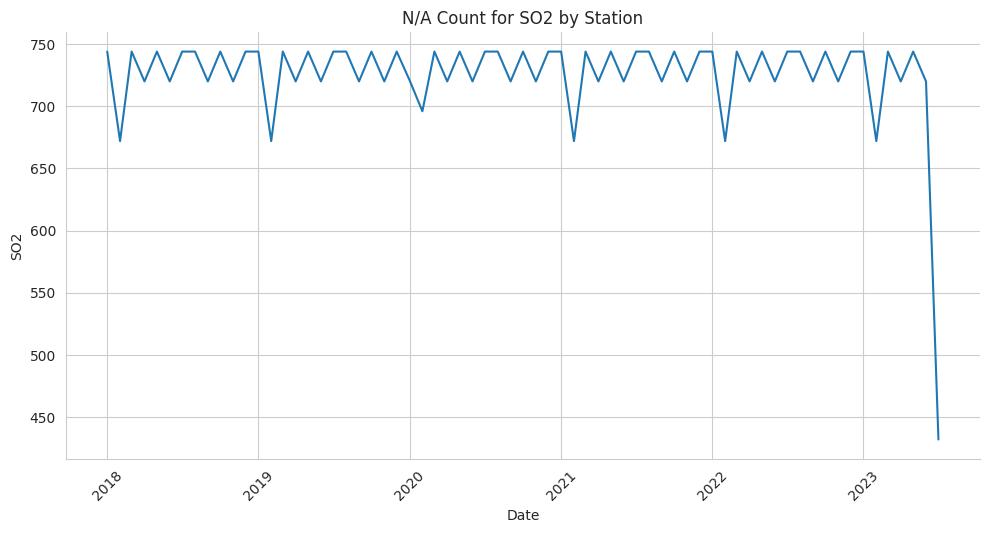

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert 'Year' and 'Month' columns to a datetime format
result_df['Date'] = pd.to_datetime(result_df[['Year', 'Month']].assign(day=1))

# Sort the DataFrame by 'Date' for plotting
result_df = result_df.sort_values('Date')

# Plot the line chart using seaborn relplot
sns.set_style("whitegrid")
g = sns.relplot(data=result_df, x='Date', y='Akureyri Strandgata (við Hof)', kind='line', aspect=2)

# Set the labels and title
plt.xlabel('Date')
plt.ylabel('SO2')
plt.title('N/A Count for SO2 by Station')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.show()






